### Stock Forecasting ORCL Stock data - Exercise-4-Timothy Gregorian

In this analysis we will examine the stock data from the company Oracle and try to train a neural model with the LSTM model to predict uptrends and downtrends in the future. The goal is to build a LSTM neural model that is able to forecast Oracle stock data for the next 5 months. 

### Link to the Dataset

https://www.kaggle.com/datasets/umerhaddii/oracle-stock-data-2024?select=ORCL_1986-03-12_2025-08-16.csv

### Information about the dataset

The Oracle dataset contains 9935 stock data entries from the date 1986-03-12 to 2025-08-16, with important variables like: date, open, high, low, close, adj_close and volume.

The main variable we will be focusing on are the variables date and close. 

### Note
Throughout this project, I followed the lecturer's GitHub examples as well as the given links about the topic RNN/LSTM.

I only used AI as well as external sources when no examples or references were available in the provided Github scripts and if certain optimizations were necessary to improve the model's performance.

### Data Description

Variables:

1) date: The trading day
2) open: Opening price of the stock on each trading day
3) high: The highest price reached during the trading day
4) low: The lowest price reached during the trading day
5) close: The final closing price  of the stock at market close
6) adj_close: Adjusted closing price after the corporate actions (usually splits or dividends)
7) volume: The total number of shares traded during the trading day.

### Import/Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("ORCL_1986-03-12_2025-08-16.csv")
df.head()

,date,open,high,low,close,adj_close,volume
0,NaN,ORCL,ORCL,ORCL,ORCL,ORCL,ORCL
1,1986-03-12,0.06327199935913086,0.06404300034046173,0.06327199935913086,0.06327199935913086,0.05081019923090935,393012000
2,1986-03-13,0.06481499969959259,0.06558600068092346,0.06481499969959259,0.06481499969959259,0.052049294114112854,125290800
3,1986-03-14,0.06712999939918518,0.06790100038051605,0.06712999939918518,0.06712999939918518,0.053908348083496094,57866400
4,1986-03-17,0.06635800004005432,0.06635800004005432,0.06558600068092346,0.06558600068092346,0.052668459713459015,28285200


We drop all the variables except for the date and close.

In [3]:
df = df.drop(columns=["open", "high", "low", "adj_close", "volume"])

After seeing in the LSTM-MSFT-Time-Series-Forecasting project, that filtering a wide range of stock data, will lead to a chaotic model prediciton, since major events like Corona mess up long-term predictions, even though we use LSTM layers in our neural model, I filtered 2 and a half years of Oracle stock data.

In [4]:
df = df[(df["date"] >= "2023-01-01") & (df["date"] <= "2025-08-15")]
df.head()


,date,close
9279,2023-01-03,83.72000122070312
9280,2023-01-04,84.4800033569336
9281,2023-01-05,84.30999755859375
9282,2023-01-06,85.66000366210938
9283,2023-01-09,86.41999816894531


In [5]:
df.tail()

,date,close
9931,2025-08-11,252.67999267578125
9932,2025-08-12,253.86000061035156
9933,2025-08-13,244.17999267578125
9934,2025-08-14,244.9600067138672
9935,2025-08-15,248.27999877929688


In [6]:
len(df)

657

In [7]:
df

,date,close
9279,2023-01-03,83.72000122070312
9280,2023-01-04,84.4800033569336
9281,2023-01-05,84.30999755859375
9282,2023-01-06,85.66000366210938
9283,2023-01-09,86.41999816894531
...,...,...
9931,2025-08-11,252.67999267578125
9932,2025-08-12,253.86000061035156
9933,2025-08-13,244.17999267578125
9934,2025-08-14,244.9600067138672


No duplicates in the dataset.

In [8]:
print(df.duplicated().sum())

0


Also no missing values.

In [9]:
print(df.isnull().sum())

date     0
close    0
dtype: int64


In [10]:
value_column = 'close'

In [11]:
scaler = MinMaxScaler()
df[[value_column]] = scaler.fit_transform(df[[value_column]])


df = df.drop("date", axis=1)
df.index = df.index * 0.1 + 1

In [12]:
df.head()

,close
928.9,0.004266
929.0,0.008648
929.1,0.007668
929.2,0.015451
929.3,0.019833


In [ ]:
cutoff = int(len(df) * 0.8)

X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]

X_test = df.index[cutoff:]
y_test = df[value_column].iloc[cutoff:]

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

n_features = 1

train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

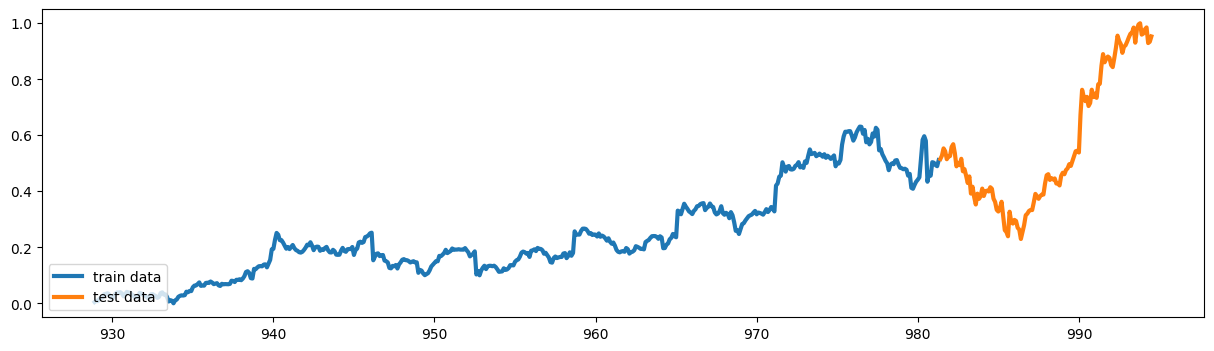

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

I have used the same amount for the look_back variable as in the other project (LSTM_MSFT_Time_Series_Stockdataset.ipynb), to test if I get a good R²-score. But personally I feel like that everytime we filter 2 and a half years of stock data from any company and use the number 40 for the look_back variable, we get a good R²-score in general.

For this project, I have also used the tensorflow dataset.

In [15]:
from tensorflow.keras.utils import timeseries_dataset_from_array

look_back  = 40
batch_size = 16
window_size = 1

train_generator = timeseries_dataset_from_array(
    data=train_series,
    targets=train_series[look_back:],
    sequence_length=look_back,
    sampling_rate=1,
    sequence_stride=window_size,
    batch_size=batch_size,
    shuffle=False,
)

test_generator = timeseries_dataset_from_array(
    data=test_series,
    targets=test_series[look_back:],
    sequence_length=look_back,
    sampling_rate=1,
    sequence_stride=window_size,
    batch_size=batch_size,
    shuffle=False,
)

In general when we use 700 data entries of stock data the neural model with a single LSTM layer of 32 neurons and two Dense layers works best, to achieve the best neural model structure as well as the best model training.

The more LSTM layers I use and the more neurons I add to the LSTM and Dense layers, the more the val_loss becomes and the more the model quality decreases.

In [ ]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_model_ORCL_forecast.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(LSTM(32, activation="relu"))
model.add(Dense(16, activation="relu"))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(train_generator, epochs=30, verbose=1, validation_data=test_generator, callbacks=callback_list)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0155 - val_loss: 0.0211
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0241 - val_loss: 0.0635
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - val_loss: 0.0117
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - val_loss: 0.0085
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 0.0079
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - val_loss: 0.0060
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 12/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - v

Even though the visualisation shows that val_loss fluctuates strong once in the graph and after that stays steady, it still has a better model performance than the model performance with the MSFT stock data.

<Axes: >

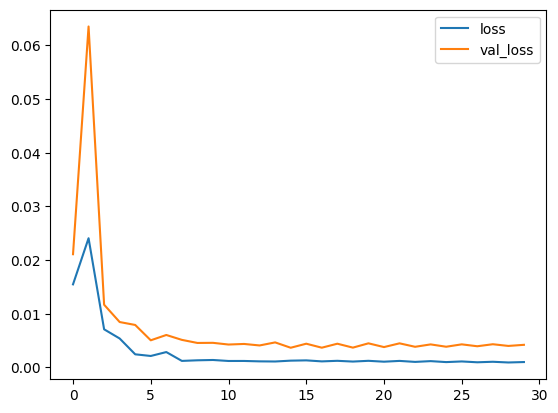

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [ ]:
from keras.models import load_model
model = load_model("best_model_ORCL_forecast.keras")

The train evaluation results show low numbers in both training and testing loss, which means that the model generalizes well and is not overfitting.

In [ ]:
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 
Training loss: 0.001769436988979578
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 
Testing loss: 0.003663010662421584


In [21]:
test_predictions  = model.predict(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


The model has a solid predictive performance. The MAE and MSE values are both very small. The MAPE value is also very low, indicating that the model maintains a low percentage-based error. We also have a very solid R²-score of 0.95, in the error metrics of the MSFT project, the error metrics were 0.81.

In [ ]:
actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
8.88 %

MAE
0.04 units

MSE
0.0 units^2

RMSE:
0.06 units

R-squared:
0.95


In the visualization below, the red curve shows the model's prediction, while the light green curve shows the actual stock prices of the dataset. 

I notice that although the predicted line is noticeably smoother than the real data, we can still see an overall upward trend. The model does also not replicate the short-term fluctuations in the actual data, but it can follow the general direction of the price movement.

This shows that LSTM models are able to learn long-term patterns better than RNN models.

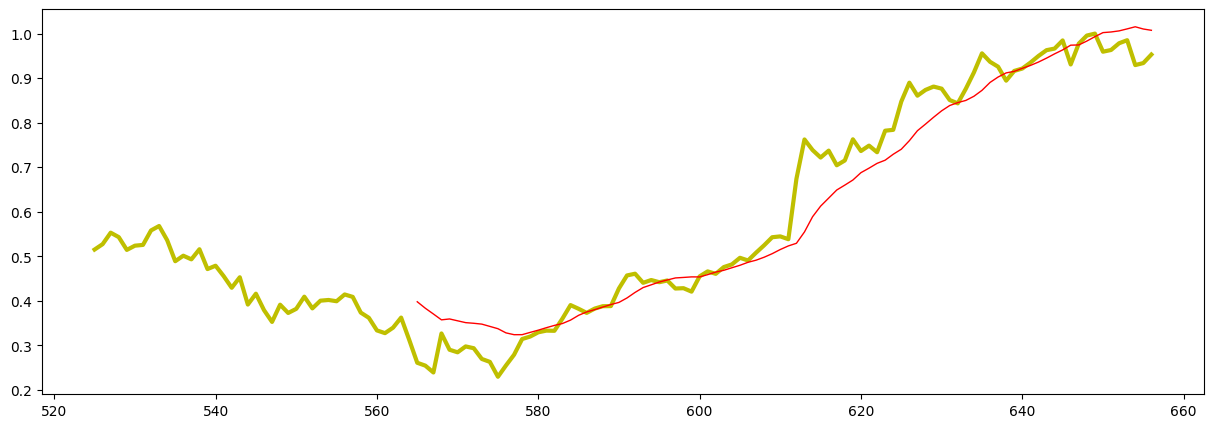

In [ ]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

Both training and testing loss are very small and close to each other, meaning that the model learned the patterns in the training data also well.

In [ ]:
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

result = model.evaluate(test_generator)
print(f"Testing losSs: {result}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Training loss: 0.001769436988979578
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 
Testing loss: 0.003663010662421584


In the forecast code below, I have used a "look_back" value of 40, which means the model always looks at the last 40 time steps to predict the next value, which has worked the best out of all the other values I have chosen from. I have also used 160 iterations for the for-loop and as we can see in the graph below, we have an overall smooth upward trend predicted for the next 5 months.

In my opinion, the stock price prediction looks realistic, but they do not show short-term market fluctuations, which is a typical behavior for LSTM models trained on normalized stock data (MinMaxScaler()). LSTM models tend to produce smoothed curves instead of the volatile movements found in the visulizations of the real stock prices.

I have researched for optimizations for LSTM forecastings, to generate more realistic fluctuations in the forecast and one optimization that could work is the "autoregressive forecastings" method. The prediction code could be improved by adding random noise to each predicted step to simulate market volatility. 

This prevents the recursive loop from collapsing into a smooth curve and encourages the model to express natural fluctuations.

### Link to the Optimization (Random noise)
1) https://nishtahir.com/adding-gaussian-noise-to-a-signal-in-python

In [ ]:
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

for i in range(160):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

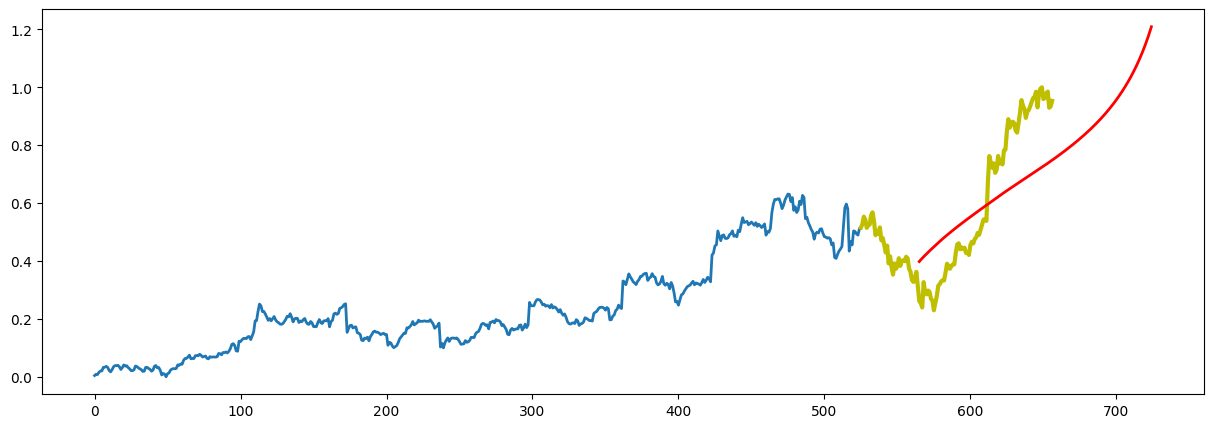

In [26]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=2, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

In [27]:
df_extra = pd.DataFrame(data=extrapolation)

The statistical summary of the extrapolated values shows that the trained model predicts higher future values, by the high mean value. There is a moderate amount of standard deviation, which show not to extreme fluctuations. The distance between the min and max value shows that the model predicts an upward trend.

In [28]:
df_extra.describe()

,0
count,160.000000
mean,0.729263
std,0.201355
min,0.398085
25%,0.570055
50%,0.708342
75%,0.864962
max,1.209092


The variance value is pretty low, which means that the model generates predictions with only small fluctuations.

In [29]:

df_extra.var()

0    0.040544
dtype: float32

### Conclusion

I built and trained an LSTM model to forecast short term predictions on Oracle stock data. Working with LSTMs for this project was also very interesting, as I was adjusting parameters like the look_back variable or the network complexity to the same numbers as in the MSFT forecast project, to get the best results.

I have gotten a better R²-score for this project than for the MSFT stock forecast project.

I personally think that in the finance sector, supply chain or even risk management, this kind of technology could be useful. Unfortunately his project made me realize that stock prices are influenced by unpredictable market events, which means that even an well-trained model cannot guarantee accurate long-term forecasts.

For optimizations, I would experiment with the "autoregressive forecast" method (gaussian-noise), so that the model to not only predict a smooth line, but also have realistic fluctuations in the prediction graph, as it is also realistic in the world of stock trading.